In [1]:
import numpy as np
import torch
import torch.optim as optim
import my_utils
import models
import utils
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
import os
from dataset import DataSet
import warnings

/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
"""
looming questions

1. should we keep the lag info by only subtracting the earliest starting light curve? does it matter?
2. how should we cut the light curves up? 
"""

# setup optuna_train properly, 

# todo list
    # predict needs to be suitable for multivariate 
# readme

    

# how do i split time? 

    # could be by a max # of points
    # could be a time threshold
    # could be an epochs threshold?
    
# who wrote the better rec letteR? 
## remove some of the accessibility to args in train 

# transfer function questions
    #bv 
    
### thesis structure
    ## gliff
    ## rm, existing stuff
    ## existing modeling: lstm autoencoders
    ## attention
    ## generative modeling
    ## hetvae
    ## training process, preprocessing etc
    
    ## applying sim data (univariate)
        ## drw, dho
    ## applying sim data (multivariate)
    
    ## applying ZTF data (univariate)
    
    ## applying ZTF data (multivariate)
    
    # what can we say about waht we learn? 
        

In [233]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
warnings.simplefilter('ignore', np.RankWarning) # set warning for polynomial fitting

## Visualize the masks

8


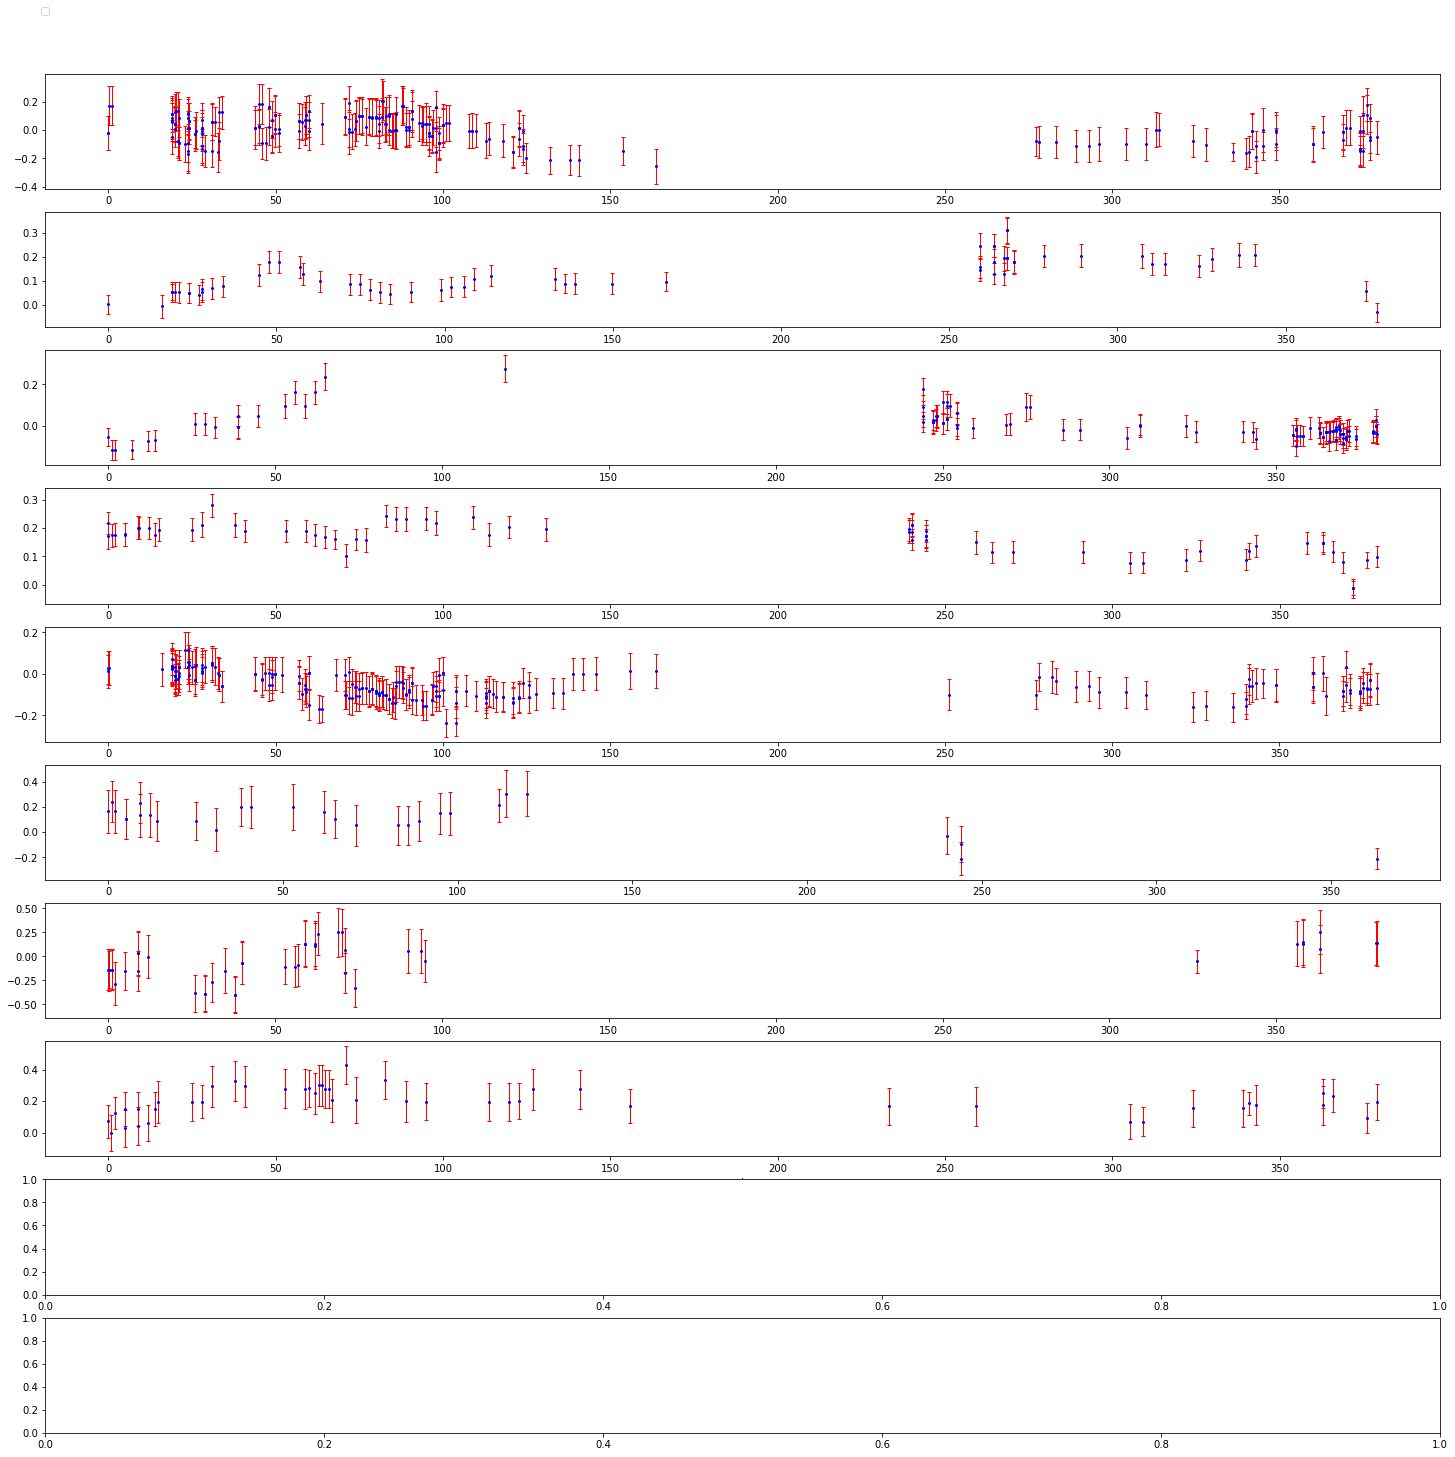

In [220]:
ZTF = my_utils.get_data(start_col=1, folder='./test_d1')
ZTF.set_target_x(num_points=400)

net, optimizer, args, epoch, loss =  my_utils.load_checkpoint('synth_4767301.h5', ZTF.data_obj)

my_utils.preview_lcs(ZTF.data_obj['train_loader'], ZTF.bands, N=10, figsize=(25,25))

In [225]:
def predict(dataloader, device='mps', k_iwae=20, subsample=False, target_x=None, plot=True, figsize=(25,15)):
    pred_mean, pred_std = [], []
    qz_mean, qz_std = [], []
    masks = []
    targets = []
    tp =[]
    target_tp = []
    np.random.seed(0)
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch_len = batch.shape[0]
            if subsample == True:
                subsampled_mask = my_utils.make_masks(batch, frac=0.5)
            else:
                subsampled_mask = my_utils.make_masks(batch, frac=1.0)
            batch = batch.to(device)
            subsampled_mask = subsampled_mask.to(device)
            recon_mask = torch.logical_xor(batch[:,:,:,1], subsampled_mask)
            context_y = torch.cat((batch[:,:,:,1] * subsampled_mask, subsampled_mask), 1).transpose(2,1)

            
            if target_x is not None:
                tx = torch.tensor(target_x[i*batch_len:(i*batch_len + batch_len)])[:,0]
            else:
                tx = batch[:, 0, :,0]
            print(tx.shape)
            px, qz = net.get_reconstruction(batch[:, 0, :,0], context_y, tx, num_samples=k_iwae)
            pred_mean.append(px.mean.cpu().numpy())
            pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
            qz_mean.append(qz.mean.cpu().numpy())
            qz_std.append(torch.exp(0.5 * qz.logvar).cpu().numpy())
            
            targets.append((batch[:, :, :,1]).cpu().numpy())
            masks.append(subsampled_mask.cpu().numpy())
            tp.append(batch[:, 0, :,0].cpu().numpy())
            target_tp.append(tx.cpu().numpy())
      
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    qz_mean = np.concatenate(qz_mean, axis=0)
    qz_std = np.concatenate(qz_std, axis=0)
    
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    target_tp = np.concatenate(target_tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    inputs = np.transpose(inputs, [0,2,1])
    # reparam trick
    preds = np.random.randn(k_iwae//2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    
    qz_preds = np.random.randn(k_iwae//2, k_iwae, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2]) * qz_std + qz_mean
    qz_preds = qz_preds.reshape(-1, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2])
    qz_median = preds.mean(0)
    if plot == True:
       
        median = preds.mean(0)
        quantile2 = np.quantile(preds, 0.841, axis=0)
        quantile1 = np.quantile(preds, 0.159, axis=0)

        fig,ax = plt.subplots(5,1,figsize=figsize)
        for i in range(5):
            #### remove padding and masked vals
            nonzero_pred = target_tp[i].nonzero()[0]
            nonzero_in = inputs[i].nonzero()[0]
            
            ax[i].fill_between(target_tp[i,nonzero_pred], quantile1[i,nonzero_pred,0], quantile2[i,nonzero_pred,0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            ax[i].plot(target_tp[i, nonzero_pred], median[i, nonzero_pred])
            ax[i].scatter(tp[i, nonzero_in], inputs[i, nonzero_in])
        
    return preds, qz_preds, tp, target_tp, inputs 
      

torch.Size([8, 410])
torch.Size([8, 410])
torch.Size([8, 410])


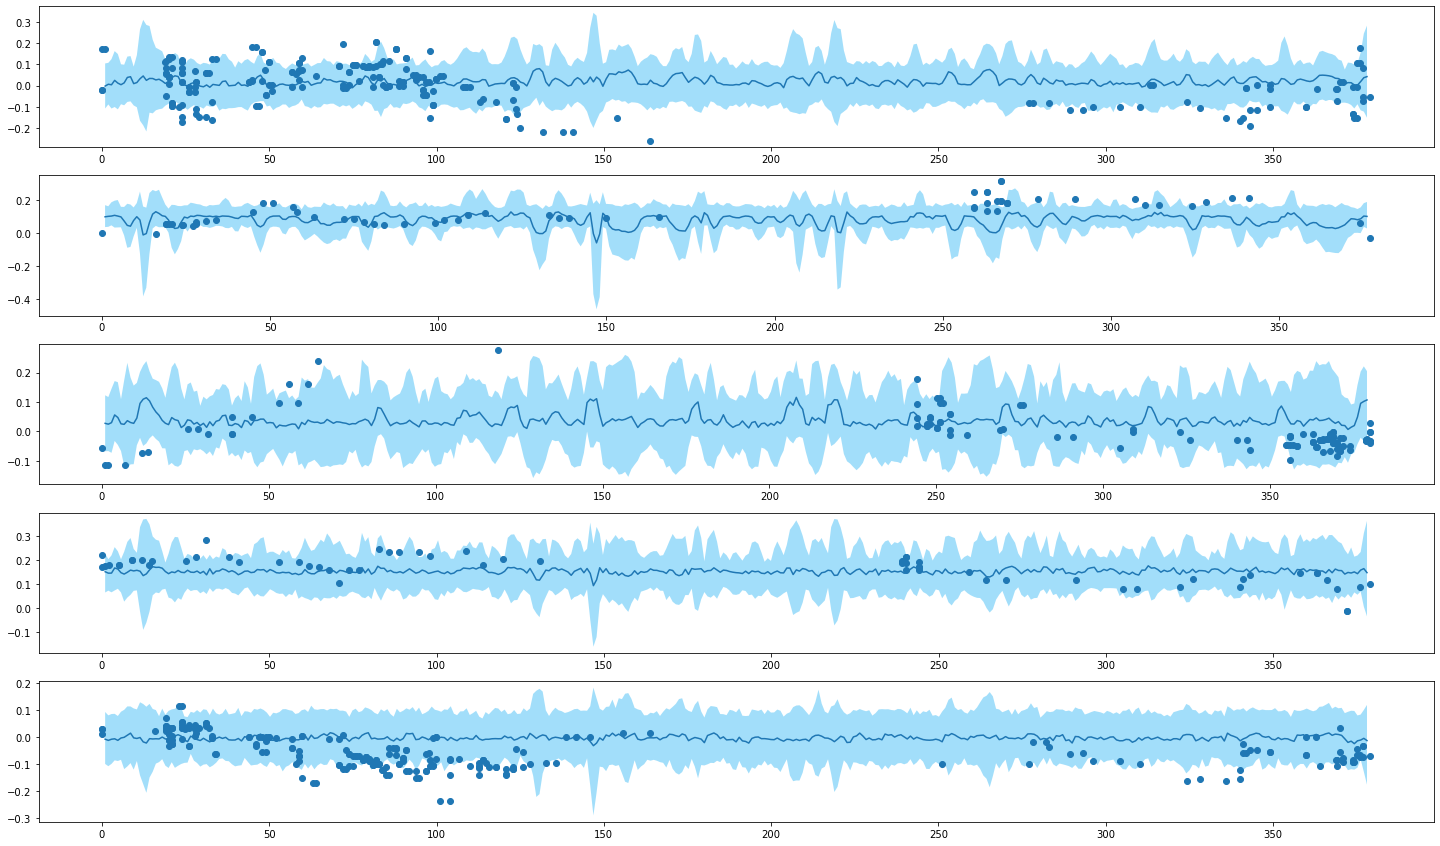

In [227]:
preds, qz_preds, tp, target_tp, inputs = predict(ZTF.data_obj['train_loader'], target_x = ZTF.target_x)

/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


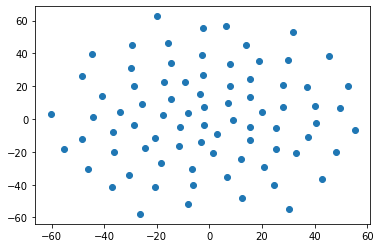

In [10]:
RS = 20150101
latent = latent.reshape((len(latent), -1))
proj = TSNE(random_state=RS).fit_transform(latent)
plt.scatter(proj[:,0], proj[:,1])

In [229]:
from eztao.carma import DRW_term, DHO_term
from eztao.ts import gpSimRand, gpSimFull
# uniform only really means we don't subsample the other dimensions? 
# firslty it should mean that the sim data we created is uniform  

## 1. make examples, what kinda distribution do we want for the dho/drw parameters? 
## 2. for each example, we would do the convolution for the transfer function
## 3. downsample for whatever cadence we want in each dimension
## 4. make masks
## 5. data loader


def get_synthetic_data(seed = 0, num_samples=100, uniform=False, dims= 1, batch_size=8, frac=0.5, sim_params={'snr':10, 'duration':10*365, 'n':200},  kernel='drw', drw_kernel_params={'tau':200, 'amp':2.5}, dho_kernel_params = {'a1':1.0, 'a2':1.0, 'b0':1.0,'b1':1.0}):
    """
    
    This function creates and loads a synthetic dataset relative to a given kernel (drw or dho) and its given parameters, which can be set via drw_kernel_params or dho_kernel_params.
    I realize that the dataset shouldn't have the same kernel parameters for each light curve, but I'm not sure how to distribute those parameters right now. 
    
    parameters:
        seed               (int)      --> random seed, this matters to keep the shuffles consistent
        num_samples        (int)      --> how many light curves in the generated dataset
        uniform            (boolean)  --> should it be a uniform sample?
        batch_size         (int)      --> for the network, usually a multiple of 2
        sim_params         (dict)     --> signal to noise (snr), (duration) in days, (n) is number of samples
        kernel             (str)      --> 'drw' (dampled random walk), a carma(1) process; 'dho' (damped harmonic oscillator), a carma(2,1) process
        drw_kernel_params  (dict)     --> 'tau' is decorelation timescale, 'amp' is the amplitude
        dho_kernel_params  (dict)     --> a1 = 2 * Xi * w0
                                          a2 = w0 ** 2
                                          b0 = sigma
                                          b1 = tau * b0
                                          wherein Xi is the damping ratio, w0 is the natural oscillation frequency, sigma is the amplitude
                                          of the short term perturbing white noise, tau is the characteristic timescale of the perturbation process
    returns:
        a dictionary of torch dataloaders with data formatted as necessary for network training 
        , as well as the dimension and union of all the time points
    """
    np.random.seed(seed)
    if kernel=='drw':
        log_amp, log_tau = np.log([drw_kernel_params['amp'], drw_kernel_params['tau']])
        kernel = DRW_term(log_amp, log_tau)
    elif kernel=='dho':
        log_a1,log_a2,log_b0,log_b1 = np.log([dho_kernel_params['a1'], dho_kernel_params['a2'], dho_kernel_params['b0'], dho_kernel_params['b1']])
        kernel=DHO_term(log_a1,log_a2,log_b0,log_b1)
    else:
        raise Exception("not a valid kernel, should be one of 'dho' or 'drw'")
    
    SNR, duration, N = sim_params['snr'], sim_params['duration'], sim_params['n']
    # gpSimRand, gpSimFull (uniform)
    if uniform=True:
        synth = np.array(gpSimFull(kernel, SNR, duration, N, nLC=num_samples)).transpose(1,2,0)[:,np.newaxis]
    else:
        synth = np.array(gpSimRand(kernel, SNR, duration, N, nLC=num_samples)).transpose(1,2,0)[:,np.newaxis]
        
    synth = np.repeat(synth, dims, axis=1)
    #############################################################
    # here we'd apply transfer function convolution along each dimension 
    #############################################################
    union_tp = np.unique(synth[:,:,:,0].flatten()).astype('float32')
    np.random.shuffle(synth)
    splindex = int(np.floor(.8*len(synth)))
    training, valid, test = np.split(synth, [splindex, splindex + int(np.floor(.1*len(synth)))])# shuffle?
    train_loader = torch.utils.data.DataLoader(training, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
    data_objects = {
        "train_loader": train_loader,
        "test_loader": test_loader,
        "valid_loader": valid_loader,
        'union_tp': union_tp,
        "input_dim": dims,
    }
    
    return data_objects

get_synthetic_data()

{'train_loader': <torch.utils.data.dataloader.DataLoader at 0x162fcdd80>,
 'test_loader': <torch.utils.data.dataloader.DataLoader at 0x28ab525f0>,
 'valid_loader': <torch.utils.data.dataloader.DataLoader at 0x28ab52920>,
 'union_tp': array([  90.16402,   90.52905,   90.89409, ..., 3556.1855 , 3556.5505 ,
        3556.9158 ], dtype=float32),
 'input_dim': 1}

In [ ]:
# visualize attetion
    # which points in the lc do the ref points pay attention to?
    # need to return the attn softmax vals

In [ ]:
# unnormalize? indexes depend on where we split the train_loader, test_loader, & valid_loader
# we shuffled with the same random seed so the indexes are the same

# also how many points are we predicting? 
def unprocess(preds, dataset):

        
